# ALGORITMO PARA IDENTIFICACIÓN SERIES DE ARMÓNICOS EN SEÑAL GENERADA

El objetivo de este programa es identificar las series de armónicos más importantes de un espectro de frecuencias dado.

El esquema principal de este script es:
* Generar la onda o señal
    * Ejemplos:
        * Onda sinusoidal
        * Suma ondas sinusoidales
        * Onda cuadrada
        * Suma ondas cuadradas
* Calculamos su espectro de frecuencias
    * Función auxiliar: get_spectrum
* Detectar picos e incertidumbres de los mismos:
    * Detección de picos con la función *encontrar_picos*
    * Funciones auxiliares creadas: *_peak_prominences*, *_peak_widths*
    * Cálculo de las incertidumbres
* Interpolación del espectro para estimar y corregir la localización de los picos
    * Función utilizada: *peak_estimator* con tipo de ventana: 'hann' o 'rect'
* Recalcular la incertidumbre de los picos
* Guardar todos los datos de picos e incertidumbres en un DataFrame
* Algoritmo principal de detección de series de armónicos
    * Introducción al algoritmo
    * Funciones auxiliares
    * Detección de series de armónicos
    * Criterios de clasificación de las series encontradas
    * Resultados obtenidos

In [1]:
from functions import get_spectrum, encontrar_picos, _peak_prominences, _peak_widths, peak_estimator

import numpy as np
from numpy import sqrt, sin, pi, sign
from numpy.fft import fft
import matplotlib.pyplot as plt
from scipy import signal

## Generamos la onda o señal

In [2]:
# Parametros iniciales
win = 'hann'
test_srate = 128.
test_freq = 9.7
test_amp = 2.0
test_nsamples = 1024
test_duration = test_nsamples/test_srate
test_resolution = test_srate/test_nsamples

# ONDA SINUSOIDAL
# test_t = np.linspace(0, test_duration, test_nsamples, endpoint=False)
# test_y = test_amp*sin(2*pi*test_freq*test_t)

# SUMA ONDAS SINUSOIDALES
# test_t = np.linspace(0, test_duration, test_nsamples, endpoint=False)
# test_y = test_amp*sin(2*pi*test_freq*test_t) + 4*sin(2*pi*test_freq*2*test_t) + 5*sin(2*pi*53*test_t)

# ONDA CUADRADA
test_t = np.linspace(0, test_duration, test_nsamples, endpoint=False)
test_y = test_amp * signal.square(2 * pi * test_freq * test_t)

# SUMA ONDAS CUADRADAS
# test_t = np.linspace(0, test_duration, test_nsamples, endpoint=False)
# test_y = test_amp * signal.square(2 * pi * test_freq * test_t) + 3*signal.square(2 * pi * 20 * test_t) + 5*signal.square(2 * pi * 64 * test_t)


## Calcular el espectro de frecuencias

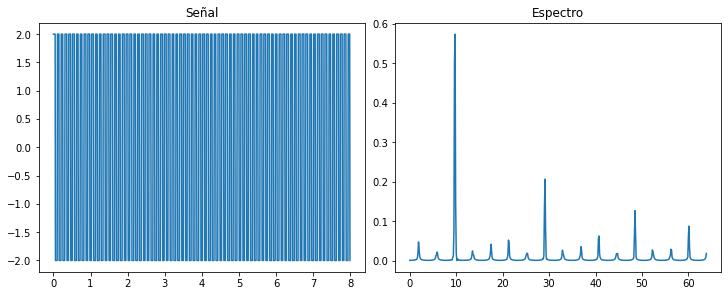

In [3]:
# Calculamos el espectro de frecuencias
test_f, test_sp = get_spectrum(test_y, test_srate, win=win)

# Mostramos las gráficas
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(10,4))
gs = gridspec.GridSpec(1, 2, figure=fig)

d0 = fig.add_subplot(gs[0, 0])
d0.plot(test_t, test_y)
d0.set_title("Señal")

d1 = fig.add_subplot(gs[0, 1])
d1.plot(test_f, test_sp)
d1.set_title("Espectro")

frecuencias = test_f
amplitudes = test_sp

## Detección de picos e incertidumbre de los mismos

In [4]:
s = np.std(amplitudes) #calculo la desviacion tipica de las amplitudes

#### MODIFICAR LOS SIGUIENTES PARÁMETROS PARA LA DETECCION DE PICOS E INCERTIDUMBRES

altura_pico = 2*s        # Minima altura para detectar un pico en la gráfica
altura_relativa = 0.75   # Altura relativa a la cual se mide la anchura del pico (en porcentaje con respecto a su prominencia)
                         # 1 significa que se mide desde la base del pico.
prominencia = None       # Prominencia: Desnivel mínimo que hay que descender desde la cima de un pico para ascender a otro, cualquiera que sea, más alto.


###### Detección de los picos

Artículo de Medium "Algorithmic Thinking and Peak Finding": 
https://rabingaire.medium.com/algorithmic-thinking-peak-finding-ad6f7415d154

In [5]:
peaks = encontrar_picos(amplitudes, altura_pico)
print("Se han detectado", len(peaks), "picos. Con los siguientes indices:", peaks) #cuantos picos hay detectados

Se han detectado 4 picos. Con los siguientes indices: [78, 233, 388, 481]


###### Funciones de Github para encontrar las incertidumbres

Para encontrar los intervalos de incertidumbre alrededor de todos los picos detectados, se van a utilizar algunas de las funciones ya creadas de la librería *scipy*. La idea es imitar el funcionamiento de la función *peak_widths (https://github.com/scipy/scipy/blob/v1.8.0/scipy/signal/_peak_finding.py#L462-L587)*.

Para ello, se han transcrito y modificado ligeramente las funciones *_peak_prominences* y *_peak_widths* que se encuentran en el siguiente enlace: https://github.com/scipy/scipy/blob/main/scipy/signal/_peak_finding_utils.pyx

##### Cálculo de las incertidumbres
Calculamos las prominencias, anchuras y extremos izquierdo y derecho de las incertidumbres con la ayuda de las funciones auxiliares anteriores.

In [6]:
prominences, left_bases, right_bases = _peak_prominences(amplitudes, peaks, 1)
widths, width_heights, left_ips, right_ips = _peak_widths(amplitudes, peaks, altura_relativa, prominences, left_bases, right_bases)

# Calculamos los valores de frecuencia (Hz) de los extremos izquierdos y derechos de las incertidumbres de cada pico
left_cotas = []
right_cotas = []

for p in range(len(peaks)):
    entera_l = int(left_ips[p])
    decimal_l = left_ips[p] - entera_l
    entera_r = int(right_ips[p])
    decimal_r = right_ips[p] - entera_r
    
    left_cotas.append((frecuencias[entera_l+1]-frecuencias[entera_l])*decimal_l + frecuencias[entera_l])
    right_cotas.append((frecuencias[entera_r+1]-frecuencias[entera_r])*decimal_r + frecuencias[entera_r])
    
# Calculamos los valores de incertidumbre en términos de valores de frecuencia (Hz)
widths_new = np.array(right_cotas) - np.array(left_cotas)
widths = widths_new.copy()

Se han detectado 4 picos con los siguientes indices: [78, 233, 388, 481]

Los picos corresponden a las siguientes frecuencias:  [ 9.75  29.125 48.5   60.125]

A estos picos se les asocia los siguientes 4 valores de incertidumbre: [0.35573069 0.38021675 0.39175308 0.39110684]


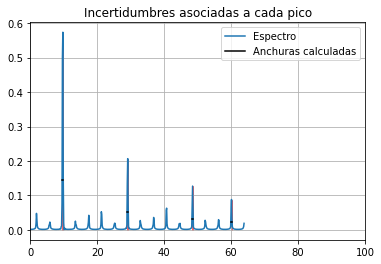

In [7]:
# Resumen y gráfica
print("Se han detectado", len(peaks), "picos con los siguientes indices:", peaks)
print("\nLos picos corresponden a las siguientes frecuencias: ", frecuencias[peaks])
print("\nA estos picos se les asocia los siguientes", len(widths), "valores de incertidumbre:", widths)

## Graficar las incertidumbres de cada pico
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.plot(frecuencias, amplitudes)
# añadimos las anchuras
for p in range(len(peaks)):
    ax.add_patch(Rectangle((left_cotas[p], 0), widths[p], amplitudes[peaks][p], color="red", alpha=0.5))
    x1 = left_cotas[p]
    x2 = right_cotas[p]
    y1 = y2 = width_heights[p]
    ax.plot([x1, x2], [y1, y2], color="black")

# mostramos el gráfico
plt.title('Incertidumbres asociadas a cada pico')
plt.legend(['Espectro', 'Anchuras calculadas'])
plt.xlim([0,100])
plt.grid()
plt.show()

## Interpolación del espectro para estimar y corregir la localización de los picos

Función utilizada: *peak_estimator* con tipo de ventana: 'hann' o 'rect'

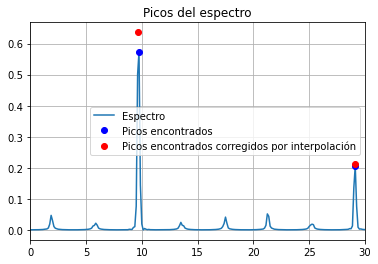

In [8]:
# Interpolación del espectro para corregir la localización de los picos
peaks_x = []
peaks_y = []

for p in peaks:
    try:
        x, y = peak_estimator(frecuencias[p-1:p+2], amplitudes[p-1:p+2], win='hann')
        peaks_x.append(x)
        peaks_y.append(y)
        
    except ValueError:
        print("Error en pico", p, ". Intervalo:", (frecuencias[p-1:p+2], amplitudes[p-1:p+2]))
        

# mostrar los resultados
plt.plot(frecuencias, amplitudes)
plt.plot(frecuencias[peaks], amplitudes[peaks], 'bo')
plt.plot(peaks_x, peaks_y, 'ro')
plt.title('Picos del espectro')
plt.legend(['Espectro', 'Picos encontrados', 'Picos encontrados corregidos por interpolación'])
plt.xlim([0,30])
plt.grid()

In [9]:
# Cambiamos los valores del espectro por los estimados
frecuencias_new = frecuencias.copy()
frecuencias_new[peaks] = peaks_x
amplitudes_new = amplitudes.copy()
amplitudes_new[peaks] = peaks_y

## Recalcular la incertidumbre de los picos

In [10]:
# Recalcular la anchura o incertidumbre de los nuevos picos
prominences_new, left_bases_new, right_bases_new = _peak_prominences(amplitudes_new, peaks, 1)
widths_new, width_heights_new, left_ips_new, right_ips_new = _peak_widths(amplitudes_new, peaks, altura_relativa, prominences_new, left_bases_new, right_bases_new)

# Calculamos los valores de frecuencia (Hz) de los extremos izquierdos y derechos de las incertidumbres de cada pico
left_cotas_new = []
right_cotas_new = []

for p in range(len(peaks)):
    entera_l = int(left_ips_new[p])
    decimal_l = left_ips_new[p] - entera_l
    entera_r = int(right_ips_new[p])
    decimal_r = right_ips_new[p] - entera_r
    
    left_cotas_new.append((frecuencias[entera_l+1]-frecuencias[entera_l])*decimal_l + frecuencias[entera_l])
    right_cotas_new.append((frecuencias[entera_r+1]-frecuencias[entera_r])*decimal_r + frecuencias[entera_r])
    
# Calculamos los valores de incertidumbre en términos de valores de frecuencia (Hz)
widths_new = np.array(right_cotas_new) - np.array(left_cotas_new)

Se han detectado 4 picos con los siguientes indices: [78, 233, 388, 481]

Los picos corresponden a las siguientes frecuencias:  [ 9.70023123 29.1007079  48.50208519 60.09775222]

A estos picos se les asocia los siguientes 4 valores de incertidumbre: [0.34672158 0.37653042 0.39172698 0.38564953]


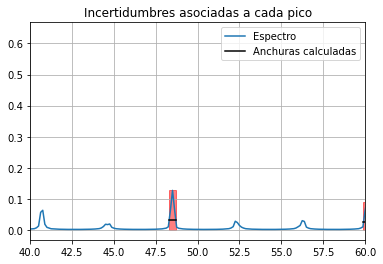

In [11]:
# Resumen y gráfica
print("Se han detectado", len(peaks), "picos con los siguientes indices:", peaks)
print("\nLos picos corresponden a las siguientes frecuencias: ", frecuencias_new[peaks])
print("\nA estos picos se les asocia los siguientes", len(widths_new), "valores de incertidumbre:", widths_new)

## Graficar las incertidumbres de cada pico
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.plot(frecuencias_new, amplitudes_new)
# añadimos las anchuras
for p in range(len(peaks)):
    ax.add_patch(Rectangle((left_cotas_new[p], 0), widths_new[p], amplitudes_new[peaks][p], color="red", alpha=0.5))
    x1 = left_cotas_new[p]
    x2 = right_cotas_new[p]
    y1 = y2 = width_heights_new[p]
    ax.plot([x1, x2], [y1, y2], color="black")

# mostramos el gráfico
plt.title('Incertidumbres asociadas a cada pico')
plt.legend(['Espectro', 'Anchuras calculadas'])
plt.xlim([40,60])
plt.grid()
plt.show()

## Guardar en un DataFrame los datos obtenidos de picos e incertidumbres

In [12]:
# Creamos el DataFrame con los datos de los picos obtenidos
import pandas as pd

datos_picos = {'Indice pico': peaks, 
               'Frecuencia dato (Hz)': frecuencias[peaks],
               'Frecuencia estimada (Hz)': frecuencias_new[peaks],
               'Anchura dato (Hz)': widths,
               'Anchura estimada (Hz)': widths_new,
               'Altura dato': amplitudes[peaks],
              'Altura estimada': amplitudes_new[peaks]}
df_picos = pd.DataFrame(datos_picos)
df_picos[0:20]

,Indice pico,Frecuencia dato (Hz),Frecuencia estimada (Hz),Anchura dato (Hz),Anchura estimada (Hz),Altura dato,Altura estimada
0,78,9.750,9.700231,0.355731,0.346722,0.573739,0.636173
1,233,29.125,29.100708,0.380217,0.376530,0.206900,0.212013
2,388,48.500,48.502085,0.391753,0.391727,0.127201,0.127224
3,481,60.125,60.097752,0.391107,0.385650,0.088249,0.091004


## Algoritmo principal de detecicón de series de armónicos

El algoritmo propuesto en este script ha sido obtenido del informe científico: *Identification of harmonics and sidebands in a finite set of spectral components (https://hal.archives-ouvertes.fr/hal-00845120v2)*.

Timothée Gerber, Nadine Martin, Corinne Mailhes. Identification of harmonics and sidebands in a finite set of spectral components. The Tenth International Conference on Condition Monitoring and Machinery Failure Prevention Technologies (CM & MFPT 2013), Jun 2013, Krakow, Poland.
hal-00845120v2

### Introducción al algoritmo


*The context of our work takes place at the output of a spectral analysis tool which provides a set S of spectral components. Within this set, each component C<sub>i</sub> is characterized by at least its central frequency ν<sub>i</sub>, the uncertainty ∆ν<sub>i</sub> directly linked to the spectral resolution and its amplitude A<sub>i</sub>.\
S = {C<sub>1</sub> (v<sub>1</sub>, ∆ν<sub>1</sub>, A<sub>1</sub>), ..., C<sub>F</sub> (v<sub>F</sub>, ∆ν<sub>F</sub>, A<sub>F</sub>)} where F is the total number of spectral components detected.*

*The purpose of this study consists then in identifying the harmonic series and sidebands in the set S of detected spectral components.*\

*Harmonic series identification from estimated components is a nontrivial problem because of estimation errors. In fact, estimation errors do not preserve the accuracy of the relation between an estimated frequency and its harmonics. So, in order to find the harmonic frequency of order r of an estimated frequency ν<sub>i</sub>, looking for a detected component at a frequency exactly equal to r × ν<sub>i</sub> will not be sufficient.\
\
In this paper, we propose to use the uncertainty ∆ν<sub>i</sub> of each detected component to bypass the drawbacks of the non-exact frequency estimation. Each estimated frequency ν<sub>i</sub> is thus represented by a confidence interval of width ∆ν<sub>i</sub> centred on ν<sub>i</sub>. The harmonic detection is then completed by intersection of these intervals, as detailed in what follows.*

##################################################

Traducción al español:\
El contexto de nuestro trabajo tiene lugar en un conjunto S de componentes espectrales calculadas anteriormente.
Dentro de este conjunto, cada componente C<sub>i</sub> se caracteriza por su frecuencia central ν<sub>i</sub>, la incertidumbre ∆ν<sub>i</sub> que está directamente ligada con la resolución espectral y su amplitud A<sub>i</sub>.\
Es decir S = {C<sub>1</sub> (v<sub>1</sub>, ∆ν<sub>1</sub>, A<sub>1</sub>), ..., C<sub>F</sub> (v<sub>F</sub>, ∆ν<sub>F</sub>, A<sub>F</sub>)} donde F es el número total de componentes espectrales detectadas.

El propósito de este estudio consiste en identificar la series armónicas y las bandas laterales del conjunto S de componentes espectrales detectadas.

La identificación de series armónicas de componentes espectrales estimadas es un problema no trivial a causa de los errores de esstimación. De hecho, los errores de estimación no preservan la precisión de la relación entre la frecuencia estimada y sus armónicos. Así que para encontrar la frecuencia del armónico de orden r de una frecuencia estimada ν<sub>i</sub>, no basta con buscar la componente detectada de la frecuencia exacta r × ν<sub>i</sub>.\

En este paper, se propone usar la incertidumbre ∆ν<sub>i</sub> de cada componente con el objetivo de evitar los inconvenientes de la estimación "no exacta" de la frecuencia. Entonces, cada frecuncia estimada ν<sub>i</sub> estará representada por un intervalo de confianza de anchura ∆ν<sub>i</sub> centrada en ν<sub>i</sub>. Posteriormente la detección de armónicos se ejecutará intersecando estos intervalos. Más detalles posteriormente.

In [13]:
F = len(peaks)                     # F: numero de componentes detectadas en el espectro
v = frecuencias_new[peaks].copy()  # v: frecuencias de los picos
Dv = widths.copy()                 # Dv: incertidumbres asociadas a cada pico de frecuencia
A = amplitudes_new[peaks].copy()   # A: amplitudes asociadas a cada pico de frecuencia

print("Tenemos", F, "componentes espectrales estimadas.")
print("\nEstas componentes corresponden a las siguientes frecuencias: \n", v)

Tenemos 4 componentes espectrales estimadas.

Estas componentes corresponden a las siguientes frecuencias: 
 [ 9.70023123 29.1007079  48.50208519 60.09775222]


In [14]:
### PARAMETROS A MODIFICAR
orden_maximo = 10*F        # Maximo orden con el cual se calcula una frecuencia de la serie

criterio_parada = 5        # Numero maximo de veces que no se encuentra armonico, tras el cual
                           # el algoritmo deja de iterar (deja de buscar armonicos en la serie)    


#### Import the main functions

In [15]:
from functions import interseccion, intervalosarmonicos, encontrar_armonico, encontrar_seriearmonica

#### Programa principal

In [16]:
## Calcular los intervalos de cada componente i

intervalo_componente = []

for j in range(F): 
    j_liminf = v[j] - (Dv[j]/2)
    j_limsup = v[j] + (Dv[j]/2)
    intervalo_componente.append( [j_liminf, j_limsup] )

In [17]:
lista_series = []
lista_numero_armonicos = []

for i in range(F):
    output, indices, numero = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    
    lista_series.append(output)
    lista_numero_armonicos.append(numero)
    
    if numero > 1:
        print("\nLa serie armonica encontrada para la componente", i, "es:", output, "y se compone de", numero, "armonicos.")



La serie armonica encontrada para la componente 0 es: [9.70041703858585, 0, 29.100707895871828, 0, 48.50208519292926] y se compone de 3 armonicos.


### Criterio de caracterización de las series

*The proposed method is exhaustive and identifies every harmonic series present in the spectrum. As a consequence, the number of series detected is large and some of them are not always relevant. Nevertheless, in the literature, there is no precise definition of a harmonic series (apart from a mathematical point of view). Moreover, the relevancy of a series depends on the application and the physical context of the studied signals. That is the reason why keeping all the series detected is necessary. Rather than eliminating the “false” series, the proposed method classifies the detected series thanks to the following three characterisation criteria.\
\
These criteria have been chosen as a comparison of each detected series to the corresponding “perfect” one. A “perfect” series is defined as a spectral comb going till the end of the spectrum with no harmonic missing.*

#########################################################################

Traducción al español:\
El método propuesto es exhaustivo e identifica todas las series armónicas presentes en el espectro. Como consecuencia, el número de series detectadas es muy grande y algunas de las series no son relevantes. Sin embargo, en la literatura, no hay una definición precisa de lo que es una serie armónica (aparte de la definición matemática). Además, la relevancia de cada serie depende de la aplicación o contexto físico de las señales estudiadas. Por esta razón, vamos a tener en cuenta todas las series detectadas. En vez de eliminar las series "incorrectas", el método propuesto clasifica las series detectadas gracias a unos criterios de caracterización.\

Estos criterios se han elegido como comparación de cada serie detectada a la serie "perfecta" correspondiente. Una serie "perfecta" se define como el peine de frecuencias que llega hasta el final del espectro y sin que le falte ningún armónico.


#### First criterion: density (D)

The first criterion denoted $D_i$, highlights the density of the series, in order to differentiate series with several harmonics missing from series with almost all harmonics present.

$D_i = \frac{\text{card}(H_i)}{r_i^{max}}$, with $r_i^{max}$ the rank of the last harmonic in the series $H_i$.

A series in which lots of harmonics are missing will have a small density whereas a "full" series including all harmonics will have a density equal to 1.

#### Primer criterio: densidad (D)

El primer criterio denotado como $D_i$ destaca la densidad de la serie, con el objetivo de diferenciar series a las cuales les faltan un número de armónicos con las series que están casi completas o completas.

$D_i = \frac{\text{card}(H_i)}{r_i^{max}}$, siendo $r_i^{max}$ el orden del último armónico encontrado en la serie $H_i$.

Una serie a la cual le faltan muchos armónicos tendrá una densidad pequeña mientras que una serie "completa" que incluya todos sus armónicos tendrá una densidad igual a 1.

In [18]:
lista_D = []

for i in range(F):
    serie, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    if numero_armonicos > 1:
        rmax = len(serie)
        H = 0
        for r in range(len(serie)):
            if (serie[r] != 0):
                H = H + 1
        D = H/rmax
    else:
        D = 0.0

    lista_D.append(D)

#### Second criterion: richness (R)

The second criterion is based on $N_i^{max}$ which is the maximum size of the series based on the frequency of its fundamental $ν_i$ and of the highest frequency $ν_F$ in the set S. This has to be compared to $r_i^{max}$ to define the second criterion, the richness $R_i$ of the series.

$R_i= \frac{r_i^{max}}{N_i^{max}}$ with $N_i^{max} = \text{int}(\frac{ν_F}{ν_i})$ with int( ) providing the integer part.

This will help to consider in a different way two series with the same cardinal and the same harmonic orders.

#### Segundo criterio: riqueza (R)

El segundo criterio se vasa en $N_i^{max}$ que es el tamaño máximo de la serie basado en su frecuencia fundamental $ν_i$ y en la frecuencia más alta $ν_F$ del conjunto S. Esto se compara con $r_i^{max}$ para definir este segundo criterio, la riqueza $R_i$ de la serie.

$R_i= \frac{r_i^{max}}{N_i^{max}}$ con $N_i^{max} = \text{int}(\frac{ν_F}{ν_i})$ siendo int( ) la parte entera.

Este criterio ayuda a considerar de manera diferente dos series con el mismo cardinal y los armónicos de los mismos órdenes.

In [19]:
lista_R = []

for i in range(F):
    serie, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    if numero_armonicos > 1:
        rmax = len(serie)
        Nmax = int(v[F-1]/serie[0])
    
        try:
            R = rmax/Nmax
        except ZeroDivisionError:
            R = 0.0   
    else: 
        R = 0.0

    lista_R.append(R)

##### Third criterion: Total Harmonic Distortion (THD)

$TDH = \frac{\sqrt{\sum \text{Power of harmonics}^2}}{\text{Power of fundamental frequency}} = \frac{\sqrt{\sum A_1^2 + ... + A_{N-1}^2}}{A_0}$, where $A_i$ is the amplitude or power of each harmonic detected $i=0,...N-1$ in the series, where $N$ is the total number of harmonics of the series.

This criterion will be helpful in applications where amplitude behaviour in harmonic series is known a priori and awaited.


##### Tercer criterio: Distorsión armónica total (THD)

$TDH = \frac{\sqrt{\sum \text{Potencia de los armónicos}^2}}{\text{Potencia de la frecuencia fundamental}} = \frac{\sqrt{\sum A_1^2 + ... + A_{N-1}^2}}{A_0}$, donde $A_i$ es la amplitud o potencia de cada componente $i=0,...N-1$ de la serie armónica, siendo $N$ el número de armónicos de dicha serie.

Este criterio es muy útil en aplicaciones donde se sabe la amplitud de la serie armónica a priori.

In [20]:
lista_THD = []

for i in range(F):
    serie, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    if numero_armonicos > 1:
        N = len(indices)
        THD = np.sqrt( sum(np.power(A[indices[1:N]], [2]*(N-1))) / (A[indices[0]]**2) )
    else:
        THD = 0.0

    lista_THD.append(THD)

#### Otro criterio que puede ser útil: número de armónicos encontrados de la serie

A desarrollar.

Este criterio también puede ser útil. El coeficiente NAS sería más alto cuántos más armónicos haya en la serie detectada.

In [21]:
lista_NAS = []

for i in range(F):
    serie, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    NAS = numero_armonicos
    lista_NAS.append(NAS)

#### Graficar las puntuaciones de los criterios para cada serie

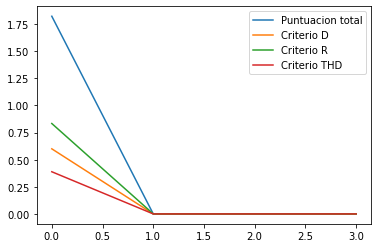

In [22]:
## Calculamos una PUNTUACION TOTAL para cada serie encontrada.
puntuacion = []
for j in range(F):
    puntuacion.append( lista_D[j] + lista_R[j] + lista_THD[j] ) #suma ponderada de puntuaciones de los criterios anteriores

plt.plot(range(F), puntuacion, range(F), lista_D, range(F), lista_R, range(F), lista_THD)
plt.legend(['Puntuacion total', 'Criterio D', 'Criterio R', 'Criterio THD'])

In [23]:
## Ordenar las series con las puntuaciones más altas a las más bajas
import pandas as pd

N = 20 #cuantas series queremos mostrar

df = pd.DataFrame([range(F), puntuacion])
df = df.transpose()
df.columns = ['Indice Serie','Puntuacion']
lista = df.nlargest(N, 'Puntuacion')['Indice Serie'] #las N series con puntuaciones más altas
lista = [int(k) for k in list(lista)]
display(df)
display(lista)

,Indice Serie,Puntuacion
0,0.0,1.821995
1,1.0,0.000000
2,2.0,0.000000
3,3.0,0.000000


[0, 1, 2, 3]

### Resultados obtenidos


Componente nº: 0
Frecuencia fundamental: 9.70041703858585
Puntuación: 1.8219953027839377
No. miembros de la serie armónica: 3
Serie armónica encontrada: [9.70041703858585, 0, 29.100707895871828, 0, 48.50208519292926]


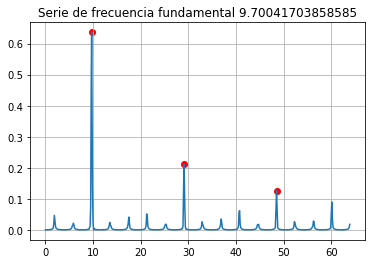

____________________________________________________________________________________________________________________

Componente nº: 1
Frecuencia fundamental: 29.100707895871828
Puntuación: 0.0
No. miembros de la serie armónica: 1
Serie armónica encontrada: [29.100707895871828]


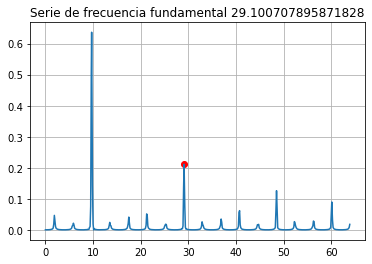

____________________________________________________________________________________________________________________

Componente nº: 2
Frecuencia fundamental: 48.50208519292926
Puntuación: 0.0
No. miembros de la serie armónica: 1
Serie armónica encontrada: [48.50208519292926]


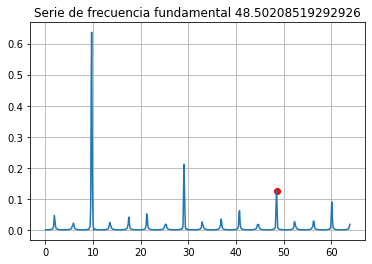

____________________________________________________________________________________________________________________

Componente nº: 3
Frecuencia fundamental: 60.09775222369136
Puntuación: 0.0
No. miembros de la serie armónica: 1
Serie armónica encontrada: [60.09775222369136]


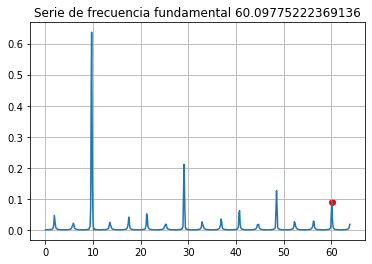

____________________________________________________________________________________________________________________


In [24]:
## Recopilamos toda la información
for i in lista:
    output, indices, numero_armonicos = encontrar_seriearmonica(i, v, Dv, intervalo_componente, orden_maximo, criterio_parada)
    print("\nComponente nº:", i)
    print("Frecuencia fundamental:", output[0])
    print("Puntuación:", puntuacion[i])
    print("No. miembros de la serie armónica:", numero_armonicos)
    print("Serie armónica encontrada:", output)
    
    plt.plot(frecuencias_new, amplitudes_new)
    plt.scatter(frecuencias_new[np.array(peaks)[indices]], amplitudes_new[np.array(peaks)[indices]], color = 'r')
    plt.title("Serie de frecuencia fundamental " + str(output[0]))
    plt.grid()
    plt.show()
    print("____________________________________________________________________________________________________________________")

In [25]:
#Recopilamos toda la informacion en un data frame

datos_series = {'Componente': range(F), 
                'Frecuencia fundamental (Hz)': frecuencias_new[peaks], 
                'Serie armonica': lista_series,
                'Numero armonicos': lista_numero_armonicos,
                'Puntuacion total': puntuacion,
                'Criterio D': lista_D,
                'Criterio R': lista_R,
                'Criterio THD': lista_THD}
df_series = pd.DataFrame(datos_series)
df_series

,Componente,Frecuencia fundamental (Hz),Serie armonica,Numero armonicos,Puntuacion total,Criterio D,Criterio R,Criterio THD
0,0,9.700231,"[9.70041703858585, 0, 29.100707895871828, 0, 4...",3,1.821995,0.6,0.833333,0.388662
1,1,29.100708,[29.100707895871828],1,0.000000,0.0,0.000000,0.000000
2,2,48.502085,[48.50208519292926],1,0.000000,0.0,0.000000,0.000000
3,3,60.097752,[60.09775222369136],1,0.000000,0.0,0.000000,0.000000


In [26]:
df_series.sort_values(by = 'Puntuacion total', ascending=False)[0:30]

,Componente,Frecuencia fundamental (Hz),Serie armonica,Numero armonicos,Puntuacion total,Criterio D,Criterio R,Criterio THD
0,0,9.700231,"[9.70041703858585, 0, 29.100707895871828, 0, 4...",3,1.821995,0.6,0.833333,0.388662
1,1,29.100708,[29.100707895871828],1,0.000000,0.0,0.000000,0.000000
2,2,48.502085,[48.50208519292926],1,0.000000,0.0,0.000000,0.000000
3,3,60.097752,[60.09775222369136],1,0.000000,0.0,0.000000,0.000000
